Imports

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


Load and Sample Data

In [5]:
# Load CSV
df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Sample to reduce memory use
df = df.sample(n=50000, random_state=42)  # Change sample size if needed
df.shape


(50000, 43)

Create Target Variable

In [6]:
df['Default'] = df['ChargeOffDate'].notna().astype(int)
df = df.dropna(subset=['Default'])
df['Default'].value_counts()


Default
0    44229
1     5771
Name: count, dtype: int64

Drop Leakage Columns

In [7]:
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])


Feature Selection

In [8]:
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

X = df[features].copy()
y = df['Default']


Feature Engineering on Dates

In [9]:
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'], errors='coerce')
X['ApprovalYear'] = X['ApprovalDate'].dt.year
X['ApprovalMonth'] = X['ApprovalDate'].dt.month
X = X.drop(columns=['ApprovalDate'])


Define Column Types

In [10]:
numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

categorical_features = [col for col in X.columns if col not in numeric_features]


Preprocessing Pipelines

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))  # sparse to save memory
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Split the Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((40000, 15), (10000, 15))

Define Training & Evaluation Function

In [29]:
def train_and_evaluate(model, model_name):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print(f" {model_name} Results")
    print("=" * 35)
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))

train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression")
train_and_evaluate(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")
train_and_evaluate(XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42), "XGBoost")


 Logistic Regression Results
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     20000
           1       0.75      0.82      0.79     20000

    accuracy                           0.77     40000
   macro avg       0.78      0.77      0.77     40000
weighted avg       0.78      0.77      0.77     40000

AUC: 0.8415661862499999
 Random Forest Results
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     20000
           1       0.90      0.92      0.91     20000

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

AUC: 0.96518498875
 XGBoost Results
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     20000
           1       0.92      0.94      0.93     20000

    accuracy                           0.93     40000
   macro avg    

Updated Code

- Dataset limited to 200,000 rows (100,000 each) before it was 360,238 rows

- current confusion matrix uses a 0.5 threshold

- Cross-validation reduced to 4 folds. Had to reduce from five because it was preventing an output

- RandomForest & XGBoost trees lowered from 100 to 70.

- Parallel processing (n_jobs=-1) enabled for RandomForest and XGBoost.

- Predict the likelihood of a loan defaulting

Balanced dataset shape: (200000, 44)
Default
1    100000
0    100000
Name: count, dtype: int64

Logistic Regression Test Results
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     20000
           1       0.75      0.82      0.79     20000

    accuracy                           0.77     40000
   macro avg       0.78      0.77      0.77     40000
weighted avg       0.78      0.77      0.77     40000

AUC: 0.8416
Confusion Matrix:
[[14517  5483]
 [ 3526 16474]]


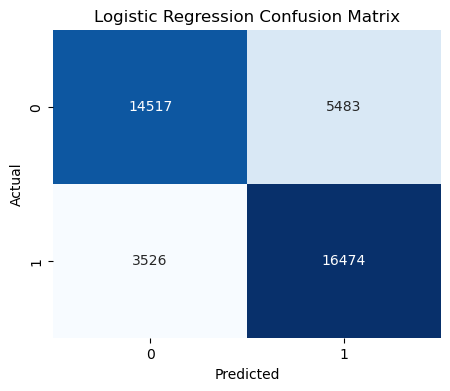


Logistic Regression Cross-Validation Metrics (4-fold)
Mean AUC: 0.8441
Mean F1:  0.7874
Mean Acc: 0.7778

Random Forest Test Results
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     20000
           1       0.90      0.92      0.91     20000

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

AUC: 0.9646
Confusion Matrix:
[[17989  2011]
 [ 1543 18457]]


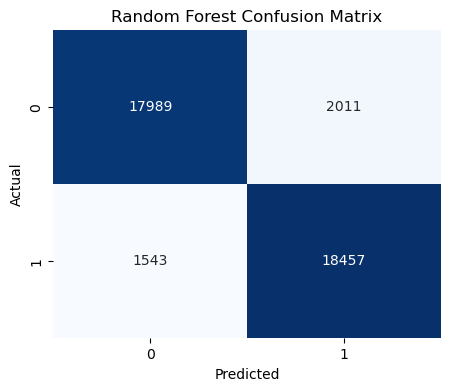


Random Forest Cross-Validation Metrics (4-fold)
Mean AUC: 0.9648
Mean F1:  0.9119
Mean Acc: 0.9109

XGBoost Test Results
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     20000
           1       0.91      0.95      0.93     20000

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000

AUC: 0.9741
Confusion Matrix:
[[18199  1801]
 [ 1092 18908]]


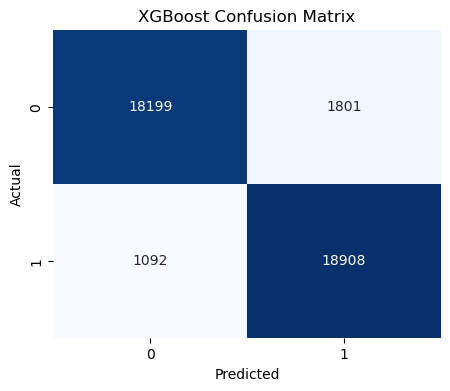


XGBoost Cross-Validation Metrics (4-fold)
Mean AUC: 0.9739
Mean F1:  0.9280
Mean Acc: 0.9267


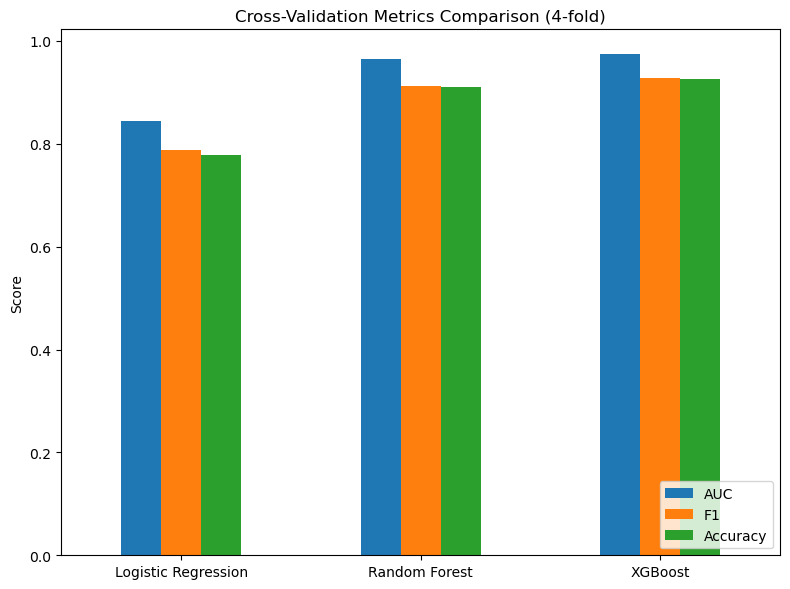

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load CSV
df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Target column
df['Default'] = df['ChargeOffDate'].notna().astype(int)
df = df.dropna(subset=['Default'])

# Balanced sample (100,000 defaults + 100,000 non-defaults)
defaults = df[df['Default'] == 1]
non_defaults = df[df['Default'] == 0]

defaults_sample = defaults.sample(n=min(100000, len(defaults)), random_state=42)
non_defaults_sample = non_defaults.sample(n=min(100000, len(non_defaults)), random_state=42)

df = pd.concat([defaults_sample, non_defaults_sample])
print(f"Balanced dataset shape: {df.shape}")
print(df['Default'].value_counts())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Features
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

X = df[features].copy()
y = df['Default']

# Process ApprovalDate
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'], errors='coerce')
X['ApprovalYear'] = X['ApprovalDate'].dt.year
X['ApprovalMonth'] = X['ApprovalDate'].dt.month
X = X.drop(columns=['ApprovalDate'])

numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Helpers

metrics_dict = {}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)  # 4-fold CV

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def cross_val_metrics(model, model_name):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    metrics_dict[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }

    print(f"\n{model_name} Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict[model_name]['Accuracy']:.4f}")

def train_and_evaluate(model, model_name):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Fit without early stopping
    clf.fit(X_train, y_train)

    inner_clf = clf.named_steps['classifier']
    if isinstance(inner_clf, XGBClassifier) and hasattr(inner_clf, 'best_iteration'):
        print(f"[{model_name}] Early stopping best_iteration: {inner_clf.best_iteration}")

    y_pred = clf.predict(X_test)
    if hasattr(clf.named_steps['classifier'], "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    print(f"\n{model_name} Test Results")
    print("=" * 50)
    print(classification_report(y_test, y_pred))
    if auc is not None:
        print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, model_name)

    # Cross-validation
    cross_val_metrics(model, model_name)

def plot_metrics_comparison(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.plot(kind='bar', figsize=(8, 6))
    plt.title("Cross-Validation Metrics Comparison (4-fold)")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# -------------------------
# Train & Evaluate
# -------------------------
train_and_evaluate(LogisticRegression(max_iter=1000, solver='liblinear'), "Logistic Regression")
train_and_evaluate(RandomForestClassifier(n_estimators=75, random_state=42, n_jobs=-1), "Random Forest")
train_and_evaluate(XGBClassifier(n_estimators=75, eval_metric='logloss',
                                 random_state=42, n_jobs=-1), "XGBoost")

# Compare CV metrics
plot_metrics_comparison(metrics_dict)


Threshold of 0.7

Balanced dataset shape: (200000, 44)
Default
1    100000
0    100000
Name: count, dtype: int64

Logistic Regression Test Results (Threshold = 0.7)
              precision    recall  f1-score   support

           0       0.67      0.90      0.76     20000
           1       0.84      0.55      0.67     20000

    accuracy                           0.72     40000
   macro avg       0.75      0.72      0.71     40000
weighted avg       0.75      0.72      0.71     40000

AUC: 0.8416
Confusion Matrix:
[[17960  2040]
 [ 9017 10983]]


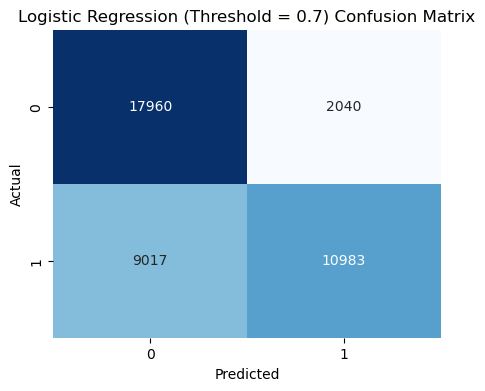


Logistic Regression Cross-Validation Metrics (4-fold)
Mean AUC: 0.8441
Mean F1:  0.7874
Mean Acc: 0.7778

Random Forest Test Results (Threshold = 0.7)
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     20000
           1       0.94      0.82      0.88     20000

    accuracy                           0.88     40000
   macro avg       0.89      0.88      0.88     40000
weighted avg       0.89      0.88      0.88     40000

AUC: 0.9646
Confusion Matrix:
[[18939  1061]
 [ 3562 16438]]


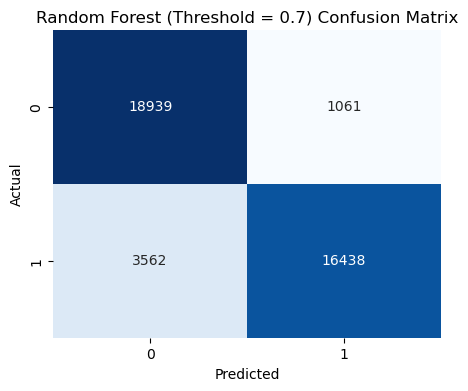


Random Forest Cross-Validation Metrics (4-fold)
Mean AUC: 0.9648
Mean F1:  0.9119
Mean Acc: 0.9109

XGBoost Test Results (Threshold = 0.7)
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     20000
           1       0.94      0.89      0.92     20000

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000

AUC: 0.9741
Confusion Matrix:
[[18886  1114]
 [ 2135 17865]]


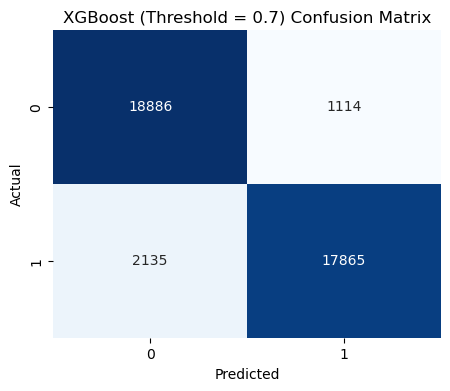


XGBoost Cross-Validation Metrics (4-fold)
Mean AUC: 0.9739
Mean F1:  0.9280
Mean Acc: 0.9267


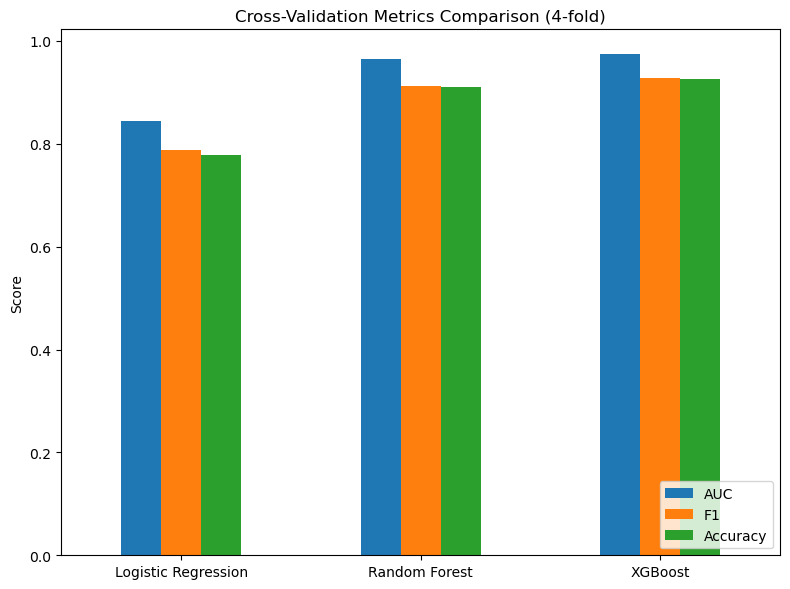

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load CSV
df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Target column
df['Default'] = df['ChargeOffDate'].notna().astype(int)
df = df.dropna(subset=['Default'])

# Balanced sample (100,000 defaults + 100,000 non-defaults)
defaults = df[df['Default'] == 1]
non_defaults = df[df['Default'] == 0]

defaults_sample = defaults.sample(n=min(100000, len(defaults)), random_state=42)
non_defaults_sample = non_defaults.sample(n=min(100000, len(non_defaults)), random_state=42)

df = pd.concat([defaults_sample, non_defaults_sample])
print(f"Balanced dataset shape: {df.shape}")
print(df['Default'].value_counts())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Features
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

X = df[features].copy()
y = df['Default']

# Process ApprovalDate
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'], errors='coerce')
X['ApprovalYear'] = X['ApprovalDate'].dt.year
X['ApprovalMonth'] = X['ApprovalDate'].dt.month
X = X.drop(columns=['ApprovalDate'])

numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Evaluation functions
metrics_dict = {}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def cross_val_metrics(model, model_name):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    metrics_dict[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }

    print(f"\n{model_name} Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict[model_name]['Accuracy']:.4f}")

def train_and_evaluate(model, model_name, threshold=0.7):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)

    inner_clf = clf.named_steps['classifier']
    if isinstance(inner_clf, XGBClassifier) and hasattr(inner_clf, 'best_iteration'):
        print(f"[{model_name}] Early stopping best_iteration: {inner_clf.best_iteration}")

    if hasattr(clf.named_steps['classifier'], "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
        auc = roc_auc_score(y_test, y_proba)
    else:
        print(f"{model_name} does not support predict_proba. Using default prediction.")
        y_pred = clf.predict(X_test)
        y_proba = None
        auc = None

    print(f"\n{model_name} Test Results (Threshold = {threshold})")
    print("=" * 60)
    print(classification_report(y_test, y_pred))
    if auc is not None:
        print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, f"{model_name} (Threshold = {threshold})")

    # Cross-validation (threshold = 0.5 by default)
    cross_val_metrics(model, model_name)

def plot_metrics_comparison(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.plot(kind='bar', figsize=(8, 6))
    plt.title("Cross-Validation Metrics Comparison (4-fold)")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# -------------------------
# Train & Evaluate Models
# -------------------------
train_and_evaluate(LogisticRegression(max_iter=1000, solver='liblinear'), "Logistic Regression", threshold=0.7)
train_and_evaluate(RandomForestClassifier(n_estimators=75, random_state=42, n_jobs=-1), "Random Forest", threshold=0.7)
train_and_evaluate(XGBClassifier(n_estimators=75, eval_metric='logloss', random_state=42, n_jobs=-1), "XGBoost", threshold=0.7)

# Compare CV metrics
plot_metrics_comparison(metrics_dict)
